In [12]:
import torch

import numpy as np
import matplotlib.pyplot as plt

import lab as B
import neuralprocesses.torch as nps

from neuralprocesses.dist import UniformDiscrete

from functools import partial

%load_ext autoreload
%autoreload 2

dtype = torch.float32

root_dir = "/scratches/cblgpu07/em626/neuralprocesses"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [201]:
from stheno import GP, EQ, Matern12
import lab as B

def mixture_log_prob(mean_diff, batch):
    
    _xc = batch["xt"][:, 0, :0]
    _yc = batch["yt"][:, 0, :0]
    
    _xt = batch["xt"][:, 0, :]
    _yt = batch["yt"][:, 0, :]
    
    all_logpdfs = []
    
    for xc, yc, xt, yt in zip(_xc, _yc, _xt, _yt):
    
        # Define mixture model:
        fs = [GP(mean_diff/2, EQ()), GP(-mean_diff/2, EQ())]
        prior = B.stack(0., 0.)
        prior -= B.logsumexp(prior)  # Make sum to one.
        noise = 0.05

        # Compute posterior probabilities of the components.
        #     Prior times likelihood:
        probs = B.stack(*[f(xc, noise).logpdf(yc) for f in fs]) + prior
        #     Divide by the evidence by normalising:
        probs = probs - B.logsumexp(probs)

        # Compute the predictive probability of the target set.
        #     Compute posteriors of processes:
        posts = [f | (f(xc, noise), yc) for f in fs]
        #     Weight the predictive probabilities by the posterior probabilities
        #     of the components:
        logpdfs = B.stack(*(f(xt, noise).logpdf(yt) for f in posts)) + probs

        # Sum over mixture components to get final predictive probability:
        all_logpdfs.append(B.logsumexp(logpdfs) / yt.shape[0])
        
    return all_logpdfs

## Helper functions

In [193]:
def make_generator_and_model(
        mean_diff: float,
        model_dir: str,
        model_params: dict,
        seed: int,
        dtype: torch.dtype = torch.float32,
    ):
    
    generator = nps.MixtureGPGenerator(
        mean_diff=mean_diff,
        dtype=dtype,
        seed=seed,
        num_context=UniformDiscrete(0, 0),
        num_target=UniformDiscrete(6, 6),
        batch_size=128,
        dim_y=1,
    )
    
    model = nps.construct_convgnp(
        **model_params
    )
    
    model.load_state_dict(torch.load(model_dir)["weights"])
    model.eval()
    
    return generator, model

In [194]:
# Make data loader and model
mean_diff = 0.
model_dir = f"{root_dir}/_experiments/mix-eq-0.0/x1_y1/convcnp/unet/loglik/model-epoch-1.torch"
model_params = {
    "points_per_unit"      : 64,
    "dim_x"                : 1,
    "dim_yc"               : (1,),
    "dim_yt"               : 1,
    "likelihood"           : "het",
    "conv_arch"            : "unet",
    "unet_channels"        : (64,) * 6,
    "unet_strides"         : (2,) * 6,
    "conv_channels"        : (64,) * 6,
    "conv_receptive_field" : 4,
    "margin"               : 0.1,
    "encoder_scales"       : None,
    "transform"            : None,
}

generator_seed = 0

generator, model = make_generator_and_model(
    mean_diff=mean_diff,
    model_dir=model_dir,
    model_params=model_params,
    seed=generator_seed,
    dtype=dtype,
)

In [195]:
state = B.create_random_state(torch.float32, seed=1)

objective = partial(
    nps.ar_loglik,
    order="random",
    normalise=True,
)

objective(
    state,
    model,
    batch["contexts"],
    batch["xt"],
    batch["yt"],
)

(<torch._C.Generator at 0x7f23f40aded0>,
 tensor([-1.8804, -2.5101, -1.6900, -2.3333, -1.3037, -1.2882, -1.1273, -1.7667,
         -1.4233, -1.2312, -1.1187, -0.8843, -2.7257, -0.9826, -0.8791, -2.6961,
         -1.0664, -1.8547, -1.2707, -0.8659, -1.9002, -1.0013, -1.2228, -1.2227,
         -1.9720, -1.0359, -1.2527, -1.8977, -1.9735, -1.2495, -1.4541, -1.1018,
         -3.1429, -2.0316, -2.0524, -1.0388, -1.0771, -1.2487, -1.1792, -1.6111,
         -2.1391, -3.8809, -1.5153, -1.5388, -1.0388, -1.3078, -1.7900, -0.7994,
         -3.4736, -1.9017, -1.6493, -1.5555, -1.5078, -1.3642, -1.1712, -1.0477,
         -1.7323, -1.7031, -2.5913, -1.4726, -3.2058, -1.8396, -0.8117, -1.8447,
         -3.1335, -1.0514, -1.7294, -2.0133, -1.7829, -1.4586, -0.9550, -1.3592,
         -1.5124, -1.0762, -2.1500, -2.2574, -1.7683, -1.0341, -0.8900, -1.4867,
         -0.9236, -2.0062, -3.0787, -0.9925, -0.7943, -1.2261, -0.9841, -2.0809,
         -1.1303, -0.9796, -1.5869, -1.1028, -1.0289, -1.0401, -1.43

In [221]:
# Random seed
seed = 0

# Evaluation parameters
num_tasks = 2**3
samples_per_task = 2**3
mean_diffs = np.linspace(0.0, 1.0, 2)

# Data loader parameters

model_params = {
    "points_per_unit"      : 64,
    "dim_x"                : 1,
    "dim_yc"               : (1,),
    "dim_yt"               : 1,
    "likelihood"           : "het",
    "conv_arch"            : "unet",
    "unet_channels"        : (64,) * 6,
    "unet_strides"         : (2,) * 6,
    "conv_channels"        : (64,) * 6,
    "conv_receptive_field" : 4,
    "margin"               : 0.1,
    "encoder_scales"       : None,
    "transform"            : None,
}

objective = partial(
    nps.ar_loglik,
    order="random",
    normalise=True,
)

results = {}
epochs = [2, 10, 20, 50, 100, 150, 200] # np.exp(np.linspace(np.log(6), np.log(200), 2))
epochs = [int(epoch) for epoch in epochs]

for generator_seed, mean_diff in enumerate(mean_diffs):
    
    results[f"mean_diff-{mean_diff}"] = {
        "epoch_means"      : [],
        "epoch_variances"  : [],
        "epoch_diff_to_gt" : [],
    }
    
    for epoch in epochs:
        
        print(f"Mean difference / epoch: {mean_diff} / {epoch}")
        
        results[f"mean_diff-{mean_diff}"][f"epoch-{epoch}"] = {}
        
        seed = 0
        state = B.create_random_state(torch.float32, seed=seed)
        
        model_dir = f"{root_dir}/_experiments/mix-eq-{mean_diff}/x1_y1/convcnp/unet/loglik/model-epoch-{epoch}.torch"
    
        generator, model = make_generator_and_model(
            mean_diff=mean_diff,
            model_dir=model_dir,
            model_params=model_params,
            seed=seed,
            dtype=dtype,
        )
        
        means = []
        variances= []
        ground_log_probs = []
        
        for _ in range(num_tasks):
            
            batch = generator.generate_batch()
            ar_log_liks = []
            
            ground_log_prob = mixture_log_prob(mean_diff=mean_diff, batch=batch)
            
            for _ in range(samples_per_task):

                state, ar_log_lik = objective(
                    state,
                    model,
                    batch["contexts"],
                    batch["xt"],
                    batch["yt"],
                )
                
                ar_log_liks.append(ar_log_lik)
                
            ar_log_liks = torch.stack(ar_log_liks, axis=0)
            
            means = means + list(torch.mean(ar_log_liks, axis=0).detach().cpu().numpy())
            variances = variances + list(torch.var(ar_log_liks, axis=0).detach().cpu().numpy())
            ground_log_probs = ground_log_probs + ground_log_prob
            
        results[f"mean_diff-{mean_diff}"][f"epoch-{epoch}"]["mean"] = np.mean(means)
        results[f"mean_diff-{mean_diff}"][f"epoch-{epoch}"]["variance"] = np.mean(variances)
        results[f"mean_diff-{mean_diff}"][f"epoch-{epoch}"]["diff_to_gt"] = torch.mean(torch.Tensor(ground_log_probs) - torch.Tensor(means))
        
        results[f"mean_diff-{mean_diff}"][f"epoch-{epoch}"]["means"] = means
        results[f"mean_diff-{mean_diff}"][f"epoch-{epoch}"]["variances"] = variances
        
        epoch_mean = results[f"mean_diff-{mean_diff}"][f"epoch-{epoch}"]["mean"]
        epoch_variance = results[f"mean_diff-{mean_diff}"][f"epoch-{epoch}"]["variance"]
        epoch_diff_to_gt = results[f"mean_diff-{mean_diff}"][f"epoch-{epoch}"]["diff_to_gt"]
        
        results[f"mean_diff-{mean_diff}"]["epoch_means"].append(epoch_mean)
        results[f"mean_diff-{mean_diff}"]["epoch_variances"].append(epoch_variance)
        results[f"mean_diff-{mean_diff}"]["epoch_diff_to_gt"].append(epoch_diff_to_gt)

Mean difference / epoch: 0.0 / 2
Mean difference / epoch: 0.0 / 10
Mean difference / epoch: 0.0 / 20
Mean difference / epoch: 0.0 / 50
Mean difference / epoch: 0.0 / 100
Mean difference / epoch: 0.0 / 150
Mean difference / epoch: 0.0 / 200
Mean difference / epoch: 1.0 / 2
Mean difference / epoch: 1.0 / 10
Mean difference / epoch: 1.0 / 20
Mean difference / epoch: 1.0 / 50
Mean difference / epoch: 1.0 / 100
Mean difference / epoch: 1.0 / 150
Mean difference / epoch: 1.0 / 200


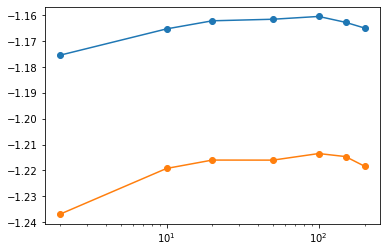

In [225]:
for generator_seed, mean_diff in enumerate(mean_diffs):
        
    plt.plot(
        epochs,
        results[f"mean_diff-{mean_diff}"]["epoch_means"],
        marker="o",
    )
        
plt.xscale("log")
# plt.yscale("log")
plt.show()

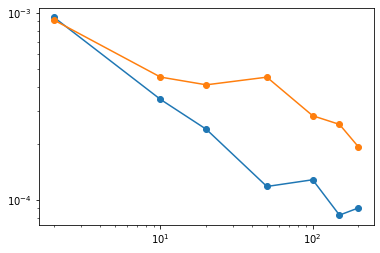

In [226]:
for generator_seed, mean_diff in enumerate(mean_diffs):

    plt.plot(
        epochs,
        results[f"mean_diff-{mean_diff}"]["epoch_variances"],
        marker="o"
    )
        
plt.xscale("log")
plt.yscale("log")
plt.show()

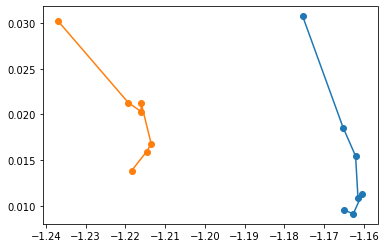

In [227]:
for generator_seed, mean_diff in enumerate(mean_diffs):

    plt.plot(
        np.array(results[f"mean_diff-{mean_diff}"]["epoch_means"]),
        np.array(results[f"mean_diff-{mean_diff}"]["epoch_variances"])**0.5,
        marker="o"
    )
        
# plt.xscale("log")
# plt.yscale("log")
# plt.xlim([0, 1])
plt.show()